# plotting action / value function variance vs density  

In [122]:
import os
os.environ['MUJOCO_GL']='egl'
# load pickle file
import pickle
import jax 
import jax.numpy as jnp 
import numpy as np 
import optax 
import haiku as hk
import time
import tqdm 
import gymnasium as gym

with open('maze_rollouts.pkl', 'rb') as f:
    data = pickle.load(f)

rollouts = []
rollout = []
for t, transition in enumerate(data):
    obs_t, obs_tp1, action, rew, terminated, truncated, info = transition

    rollout.append((obs_t, action, rew, terminated, truncated, info))
    if terminated or truncated:
        rollouts.append(rollout)
        rollout = []
        
print("number of rollouts: ", len(rollouts))
print("average length of rollout: ", sum(len(r) for r in rollouts) / len(rollouts))


number of rollouts:  41
average length of rollout:  341.3658536585366


In [123]:
obs_data = []
obs_tp1_data = []
action_data = []
action_tp1_data = []
rew_data = []
done_data = []
for rollout in rollouts:
    obs = [step[0] for step in rollout]
    obs[0] = obs[0][0]
    obs = [np.concatenate((o["observation"], o["desired_goal"])) for o in obs]
    obs_data.extend(obs[:-1])
    obs_tp1_data.extend(obs[1:])
    action_data.extend([step[2] for step in rollout][:-1])
    action_tp1_data.extend([step[2] for step in rollout][1:])
    rew_tmp = []
    for step in rollout:
        if step[4]:
            rew_tmp.append(1)
        else:
            rew_tmp.append(0)
    rew_data.extend(rew_tmp[1:])

obs_data = jnp.array(obs_data)
obs_tp1_data = jnp.array(obs_tp1_data)
action_data = jnp.array(action_data)[..., None]
action_tp1_data = jnp.array(action_tp1_data)[..., None]
rew_data = jnp.array(rew_data)
# copy rew for done
done_data = rew_data.copy()
print("obs_data shape: ", obs_data.shape, "action_data shape: ", action_data.shape)
print("obs_tp1_data shape: ", obs_tp1_data.shape, "action_tp1_data shape: ", action_tp1_data.shape)
print("rew_data shape: ", rew_data.shape)

obs_data shape:  (13955, 6) action_data shape:  (13955, 1)
obs_tp1_data shape:  (13955, 6) action_tp1_data shape:  (13955, 1)
rew_data shape:  (13955,)


In [124]:
hidden_size = 128
seed = 42
num_policies = 5
num_vfs = 5
num_epochs = 100
batch_size = 128
gamma = 0.99

# train ensemble of policies
class Policy(hk.Module):
    def __init__(self, hidden_size, action_dim):
        super().__init__()
        self.hidden_size = hidden_size
        self.action_dim = action_dim

    def __call__(self, obs):
        obs = hk.Flatten()(obs)
        obs = hk.nets.MLP([self.hidden_size, self.hidden_size, self.action_dim])(obs)
        return obs

class ValueFn(hk.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

    def __call__(self, obs):
        input = hk.Flatten()(obs)
        v1 = hk.nets.MLP([self.hidden_size, self.hidden_size, 1])(input)
        v2 = hk.nets.MLP([self.hidden_size, self.hidden_size, 1])(input)
        return v1, v2
    
class QFunction(hk.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

    def __call__(self, obs, action):
        obs = hk.Flatten()(obs)
        print(obs.shape, action.shape)
        input = jnp.concatenate([obs, action], axis=-1)
        q1 = hk.nets.MLP([self.hidden_size, self.hidden_size, 1])(input)
        q2 = hk.nets.MLP([self.hidden_size, self.hidden_size, 1])(input)
        return q1, q2

# init params
rng_key = jax.random.PRNGKey(seed)
action_dim = action_data.shape[-1]
obs_dim = obs_data.shape[-1]
sample_obs = jnp.zeros((1, obs_dim))
sample_action = jnp.zeros((1, action_dim))

@hk.transform
def policy_fn(obs):
    return Policy(hidden_size, action_dim)(obs)

@hk.transform
def v_fn(obs):
    return ValueFn(hidden_size)(obs)

@hk.transform
def q_fn(obs, action):
    if len(action.shape) == 1:
        action = jnp.expand_dims(action, axis=-1)
    # print(obs.shape, action.shape)
    return QFunction(hidden_size)(obs, action)

init_key, _ = jax.random.split(rng_key)
policy_params = jax.vmap(lambda key: policy_fn.init(key, sample_obs))(jax.random.split(init_key, num_policies))
output = jax.vmap(lambda params: hk.without_apply_rng(policy_fn).apply(params, sample_obs))(policy_params)

init_key_vf, target_key_vf, _ = jax.random.split(rng_key, 3)
vf_params = jax.vmap(lambda key: v_fn.init(key, sample_obs))(jax.random.split(init_key_vf, num_vfs))
targ_v_params = jax.vmap(lambda key: v_fn.init(key, sample_obs))(jax.random.split(target_key_vf, num_vfs))  
q_params = jax.vmap(lambda key: q_fn.init(key, sample_obs, sample_action))(jax.random.split(init_key_vf, num_vfs))
output = jax.vmap(lambda params: hk.without_apply_rng(q_fn).apply(params, sample_obs, sample_action))(q_params)
# print(output)
targ_q_params = jax.vmap(lambda key: q_fn.init(key, sample_obs, sample_action))(jax.random.split(target_key_vf, num_vfs))

# count number of params
num_params = sum([p.size for p in jax.tree_leaves(policy_params)])
print("number of policy params: ", num_params)
opt = optax.adam(1e-3)
opt_state = opt.init(policy_params)

num_vf_params = sum([p.size for p in jax.tree_leaves(vf_params)])
print("number of vf params: ", num_vf_params)
vf_opt = optax.adam(1e-3)
vf_opt_state = vf_opt.init(vf_params)

num_q_params = sum([p.size for p in jax.tree_leaves(q_params)])
print("number of qf params: ", num_q_params)
q_opt = optax.adam(1e-3)
q_opt_state = q_opt.init(q_params)

(1, 6) (1, 1)
(1, 6) (1, 1)
(1, 6) (1, 1)
number of policy params:  87685
number of vf params:  175370


/tmp/ipykernel_1167542/1319563388.py:80: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  num_params = sum([p.size for p in jax.tree_leaves(policy_params)])
/tmp/ipykernel_1167542/1319563388.py:85: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  num_vf_params = sum([p.size for p in jax.tree_leaves(vf_params)])
/tmp/ipykernel_1167542/1319563388.py:90: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  num_q_params = sum([p.size for p in jax.tree_leaves(q_params)])


number of qf params:  176650


## learn policies and value functions

In [125]:
@jax.jit
def update_step(params, opt_state, obs, action):
    def loss_fn(params):
        action_pred = jax.vmap(lambda params: hk.without_apply_rng(policy_fn).apply(params, obs))(params)
        # average over ensemble
        action_pred = jnp.mean(action_pred, axis=0)
        # mse 
        loss = jnp.mean(jnp.sum((action_pred - action)**2, axis=-1))
        return loss
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# train value function
@jax.jit
def update_vf_step(params, target_params, opt_state, obs, obs_tp1, reward, done):
    def loss_fn(params):
        v1, v2 = jax.vmap(lambda params: hk.without_apply_rng(v_fn).apply(params, obs))(params)
        v1 = jnp.mean(v1, axis=0)
        v2 = jnp.mean(v2, axis=0)
        v1 = jnp.squeeze(v1, axis=-1)
        v2 = jnp.squeeze(v2, axis=-1)
        # Bellman backup for Q functions
        # Target Q-values
        v1_t, v2_t = jax.vmap(lambda params: hk.without_apply_rng(v_fn).apply(params, obs_tp1))(target_params) 
        v1_t = jnp.mean(v1_t, axis=0)
        v2_t = jnp.mean(v2_t, axis=0)
        v1_t = jnp.squeeze(v1_t, axis=-1)
        v2_t = jnp.squeeze(v2_t, axis=-1)
        backup = reward + gamma * (1 - done) * jnp.minimum(v1_t, v2_t)
        loss_v1 = optax.squared_error(v1, backup).mean()
        loss_v2 = optax.squared_error(v2, backup).mean()
        return loss_v1 + loss_v2
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# @jax.jit
# def update_qf_step(params, target_params, opt_state, obs, action, obs_tp1, action_tp1, reward, done):
#     def loss_fn(params):
#         q1, q2 = jax.vmap(lambda params: hk.without_apply_rng(q_fn).apply(params, obs, action))(params)
#         q1 = jnp.mean(q1, axis=0)
#         q2 = jnp.mean(q2, axis=0)
#         q1 = jnp.squeeze(q1, axis=-1)
#         q2 = jnp.squeeze(q2, axis=-1)
#         # Bellman backup for Q functions
#         # Target Q-values
#         q1_t, q2_t = jax.vmap(lambda params: hk.without_apply_rng(q_fn).apply(params, obs_tp1, action_tp1))(target_params) 
#         q1_t = jnp.mean(q1_t, axis=0)
#         q2_t = jnp.mean(q2_t, axis=0)
#         q1_t = jnp.squeeze(q1_t, axis=-1)
#         q2_t = jnp.squeeze(q2_t, axis=-1)
#         # print(q1.shape, q2.shape, q1_t.shape, q2_t.shape, reward.shape)
#         backup = reward + gamma * (1 - done) * jnp.minimum(q1_t, q2_t)
#         # print(backup.shape) 
#         loss_q1 = optax.squared_error(q1, backup).mean()
#         loss_q2 = optax.squared_error(q2, backup).mean()
#         return loss_q1 + loss_q2
    
#     loss, grads = jax.value_and_grad(loss_fn)(params)
#     updates, opt_state = opt.update(grads, opt_state)
#     new_params = optax.apply_updates(params, updates)
#     return new_params, opt_state, loss

# train policy
# for epoch in tqdm.tqdm(range(num_epochs)):
#     epoch_loss = 0.0
#     num_batches = len(obs_data) // batch_size
#     for i in range(0, len(obs_data), batch_size):
#         obs_batch = obs_data[i:i+batch_size]
#         action_batch = action_data[i:i+batch_size]
#         start = time.time()
#         policy_params, opt_state, loss = update_step(policy_params, opt_state, obs_batch, action_batch)
#         end = time.time()
#         epoch_loss += loss
#     epoch_loss /= num_batches
#     if epoch % 10 == 0:
#         print(f"epoch: {epoch}, loss: {epoch_loss}")

# train q ensemble
num_batches = len(obs_data) // batch_size
print("num_batches: ", num_batches)
for epoch in tqdm.tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for i in range(0, len(obs_data), batch_size):

        obs_batch = obs_data[i:i+batch_size]
        action_batch = action_data[i:i+batch_size]
        obs_tp1_batch = obs_tp1_data[i:i+batch_size]
        action_tp1_batch = action_tp1_data[i:i+batch_size]
        rew_batch = rew_data[i:i+batch_size]
        done_batch = done_data[i:i+batch_size]

        start = time.time()
        # q_params, q_opt_state, q_loss = update_vf_step(
        #     q_params, 
        #     targ_q_params, 
        #     q_opt_state, 
        #     obs_batch, 
        #     action_batch,
        #     obs_tp1_batch,
        #     action_tp1_batch,
        #     rew_batch,
        #     done_batch
        # )
        vf_params, vf_opt_state, v_loss = update_vf_step(
            vf_params, 
            targ_v_params, 
            vf_opt_state, 
            obs_batch, 
            obs_tp1_batch,
            rew_batch,
            done_batch
        )
        # polyak averaging for target value function
        tau = 0.005
        targ_v_params = jax.tree_util.tree_map(lambda p, tp: tau * p + (1 - tau) * tp, vf_params, targ_v_params)
        # targ_q_params = jax.tree_util.tree_map(lambda p, tp: tau * p + (1 - tau) * tp, q_params, targ_q_params)
        end = time.time()
        # print("time: ", end - start)    
        # epoch_loss += q_loss
        epoch_loss += v_loss
        # skip the final batch
        if i == len(obs_data) - batch_size:
            break

    epoch_loss /= num_batches
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss: {epoch_loss}")


num_batches:  109


  1%|          | 1/100 [00:21<35:38, 21.60s/it]

epoch: 0, loss: 0.06717753410339355


 11%|█         | 11/100 [02:46<19:44, 13.31s/it]

epoch: 10, loss: 0.004176003858447075


 21%|██        | 21/100 [05:29<21:53, 16.63s/it]

epoch: 20, loss: 0.00044686009641736746


 31%|███       | 31/100 [08:09<16:02, 13.95s/it]

epoch: 30, loss: 0.0010482154320925474


 41%|████      | 41/100 [10:36<16:09, 16.43s/it]

epoch: 40, loss: 0.00012176143354736269


 51%|█████     | 51/100 [13:36<11:56, 14.63s/it]

epoch: 50, loss: 0.00022462185006588697


 61%|██████    | 61/100 [15:19<09:13, 14.19s/it]

epoch: 60, loss: 0.00017889034643303603


 71%|███████   | 71/100 [18:40<08:23, 17.36s/it]

epoch: 70, loss: 4.55031986348331e-05


 81%|████████  | 81/100 [19:55<03:19, 10.49s/it]

epoch: 80, loss: 5.29593562532682e-05


 91%|█████████ | 91/100 [23:33<03:16, 21.86s/it]

epoch: 90, loss: 6.177955219754949e-05


100%|██████████| 100/100 [24:32<00:00, 14.73s/it]


In [126]:
# checkpointing 
with open('results/vf_params_goal.pkl', 'wb') as f:
    pickle.dump(vf_params, f)

In [13]:
# load checkpoint
with open('results/policy_params.pkl', 'rb') as f:
    policy_params = pickle.load(f)

In [19]:
map = [[1, 1, 1, 1, 1, 1, 1],
        [1, "g", "g", "g", "g", "g", 1],
        [1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, "r", 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1]]

env_id = 'PointMaze_UMazeDense-v3'
num_eval_epiosdes = 1
env = gym.make(
    env_id, 
    maze_map=map, 
    continuing_task=False, 
    reset_target=False, 
    render_mode="rgb_array", 
    max_episode_steps=1000,
    reward_type="dense"
)

# run rollout 
images = []
for _ in range(num_eval_epiosdes):
    obs, _ = env.reset()
    # concatenate the goal to the observation
    obs = np.concatenate([obs["observation"], obs["desired_goal"]])
    done = False
    t = 0
    while not done:
        action = jax.vmap(lambda params: hk.without_apply_rng(policy_fn).apply(params, obs))(policy_params)
        action = jnp.mean(action, axis=0)
        action_variance = jnp.var(action, axis=0)
        obs, rew, done, truncated, _ = env.step(action)
        obs = np.concatenate([obs["observation"], obs["desired_goal"]])
        img = env.render()
        print("action: ", action, "action variance: ", action_variance)
        print(f"t: {t} reward: ", rew)
        done = done or truncated
        t += 1
        images.append(img)

action:  [-0.02109982  0.05816426] action variance:  0.0015706986
t: 0 reward:  0.012410428835804215
action:  [-0.02331096  0.06535804] action variance:  0.001965548
t: 1 reward:  0.012414288203998558
action:  [-0.02571505  0.07344317] action variance:  0.002458088
t: 2 reward:  0.012420433012513759
action:  [-0.02882118  0.0813417 ] action variance:  0.0030339654
t: 3 reward:  0.012429110563820369
action:  [-0.03268984  0.089317  ] action variance:  0.003721417
t: 4 reward:  0.012440577554903826
action:  [-0.0369932   0.09593288] action variance:  0.0044173356
t: 5 reward:  0.012455056944736514
action:  [-0.03999223  0.09571976] action variance:  0.0046044365
t: 6 reward:  0.01247256814698363
action:  [-0.04259599  0.09544039] action variance:  0.004763511
t: 7 reward:  0.012493127948327971
action:  [-0.04462784  0.09537795] action variance:  0.0049004056
t: 8 reward:  0.012516757367317288
action:  [-0.04457638  0.09620374] action variance:  0.0049547604
t: 9 reward:  0.01254348985238

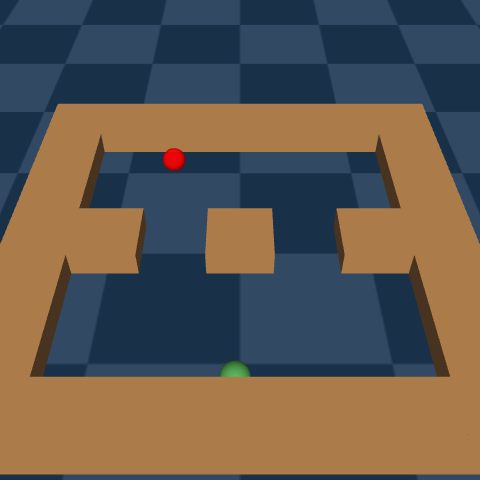

In [20]:
# make gif from images
import imageio
imageio.mimsave('results/policy.gif', images, duration=0.05)
# render gif
from IPython.display import Image
Image(filename='results/policy.gif')